In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
 from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
# import cv2
import glob
import shutil

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
!nvidia-smi

Sat Jun 19 10:15:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Parameters

In [ ]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/skin_lesion/DCGAN/akiec/gan_input/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 257

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of images to save
image_sample_size = 1

OUT_DIR = '/content/drive/MyDrive/skin_lesion/DCGAN/bcc/saved_images/output/'

## Data Preparation

In [ ]:
# For GAN Input
# os.chdir(/content/drive/MyDrive/skin_lesion/Classification/df/)
# !cp /content/drive/MyDrive/skin_lesion/Classification/bcc/*jpg /content/drive/MyDrive/skin_lesion/test_data/bcc/*jpg /content/drive/MyDrive/skin_lesion/DCGAN/bcc/gan_input/bcc/



# For FID
# !cp /content/drive/MyDrive/skin_lesion/DCGAN/vasc/gan_input/vasc/*jpg /content/drive/MyDrive/skin_lesion/DCGAN/fid/vasc/part_1/


In [ ]:
# Split data into 50%

# src = '/content/drive/MyDrive/skin_lesion/DCGAN/fid/vasc/part_1/'

# dst = '/content/drive/MyDrive/skin_lesion/DCGAN/fid/vasc/part_2/'


# def move_file(src,des,percent):
#   files_list = os.listdir(src)
#   splitVal = int(round(percent*len(files_list)))
#   files = files_list[splitVal:]
#   print(splitVal)
#   # now iterate through the two list and copy the files to respective
#   # directory using shutil.copy(file_name,dest_dir)

#   for f in files:
#     shutil.move(os.path.join(src, f), dst)

# move_file(src,dst,0.5)

71


In [ ]:
# Resize


# import PIL
# import os
# from PIL import Image
# f = r'/content/drive/MyDrive/skin_lesion/DCGAN/bkl/gan_input/bkl/'
# os.listdir(f)
# for file in os.listdir(f):
#     f_img = f+"/"+file
#     img = Image.open(f_img)
#     img = img.resize((64,64))
#     img.save(f_img)

## Training Data

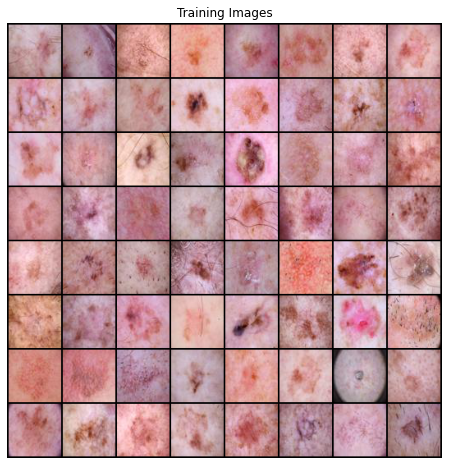

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:

# # Decide which device we want to run on
# device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
print(len(dataloader.dataset))

514


## Model

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# def zip_images(filename='images.zip'):
#     # SAVE TO ZIP FILE NAMED IMAGES.ZIP
#     z = zipfile.PyZipFile(filename, mode='w')
#     for k in range(image_sample_size):
#         with torch.no_grad():
#                 generated_image = netG(torch.randn(1, nz, 1, 1, device=device)).detach().cpu()
#         f = str(k)+'.jpg'
#         img = np.array(generated_image[0])
#         img = (img[0, :, :, :] + 1.) / 2.
#         img = Image.fromarray((255*img).astype('uint8').reshape((64,64,3)))
#         img.save(f,'JPG')
#         z.write(f)
#         os.remove(f)
#         #if k % 1000==0: print(k)
#     z.close()
#     print('Saved final images for submission.')



# def save_images(image_sample_size):
#     for k in range(image_sample_size):
#         with torch.no_grad():
#                 generated_image = netG(torch.randn(1, nz, 1, 1, device=device)).detach().cpu()
#         f = str(k)+'.png'
#         f = os.path.join(directory, f)
#         img = np.array(generated_image[0])
#         img = cv2.merge((255*img[2], 255*img[1], 255*img[0]))  # Use opencv to merge as b,g,r
#         # img = np.transpose(img)
#         # img = (img[0, :, :, :] + 1.) / 2.
#         # img = Image.fromarray((255*img).astype('uint8'),'RGB')
#         # print(img.shape)
#         # img.save(f,'PNG')
#         cv2.imwrite(f, img)
#         #if k % 1000==0: print(k)
#     print('Saved temporary images for evaluation.')

## Training

In [ ]:
# Training Loop

# Specify a path to save to
# PATH = "/content/drive/MyDrive/skin_lesion/DCGAN/bkl/saved_models/model.pt"

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        # if i % 50 == 0:
        #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #           % (epoch, num_epochs, i, len(dataloader),
        #              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


            # directory = f'/content/drive/MyDrive/skin_lesion/DCGAN/bkl/output/output_bkl_{iters}'
            # os.mkdir(directory)

            # with torch.no_grad():
            #     generated_image = netG(fixed_noise_op).detach().cpu()

            # img_list_temp.append(vutils.make_grid(generated_image, padding=0, normalize=True))


            # Saving Images to drive
            # for k in range(image_sample_size):
            #     with torch.no_grad():
            #         generated_image = netG(fixed_noise_op).detach().cpu()
            #     f = str(k)+'.jpg'
            #     f = os.path.join(directory, f)
            #     img = np.array(generated_image[0])
            #     img = cv2.merge((255*img[2], 255*img[1], 255*img[0]))
            #     cv2.imwrite(f, img)
            # print('Saved images for evaluation.')

            #Saving model to drive
            torch.save({
            'modelG_state_dict': netG.state_dict(),
            'modelD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, f"/content/drive/MyDrive/skin_lesion/DCGAN/bcc/saved_models/model_{iters}.pt")

        iters += 1

Starting Training Loop...
[0/2000][0/2]	Loss_D: 1.9084	Loss_G: 4.3822	D(x): 0.4462	D(G(z)): 0.5645 / 0.0200
[0/2000][1/2]	Loss_D: 1.6701	Loss_G: 5.5544	D(x): 0.9314	D(G(z)): 0.7255 / 0.0077
[1/2000][0/2]	Loss_D: 0.8770	Loss_G: 6.5663	D(x): 0.8745	D(G(z)): 0.4228 / 0.0024
[1/2000][1/2]	Loss_D: 0.6131	Loss_G: 6.2972	D(x): 0.8346	D(G(z)): 0.1917 / 0.0034
[2/2000][0/2]	Loss_D: 0.5525	Loss_G: 6.4026	D(x): 0.8816	D(G(z)): 0.2508 / 0.0026
[2/2000][1/2]	Loss_D: 0.6755	Loss_G: 7.7557	D(x): 0.9022	D(G(z)): 0.3660 / 0.0008
[3/2000][0/2]	Loss_D: 0.4267	Loss_G: 7.5942	D(x): 0.8758	D(G(z)): 0.1887 / 0.0009
[3/2000][1/2]	Loss_D: 0.3805	Loss_G: 8.0497	D(x): 0.9178	D(G(z)): 0.2182 / 0.0005
[4/2000][0/2]	Loss_D: 0.3679	Loss_G: 8.8404	D(x): 0.9193	D(G(z)): 0.2149 / 0.0002
[4/2000][1/2]	Loss_D: 0.2568	Loss_G: 8.5778	D(x): 0.9169	D(G(z)): 0.1287 / 0.0003
[5/2000][0/2]	Loss_D: 0.2698	Loss_G: 9.4647	D(x): 0.9348	D(G(z)): 0.1650 / 0.0001
[5/2000][1/2]	Loss_D: 0.1609	Loss_G: 8.5554	D(x): 0.9301	D(G(z)): 0.0700

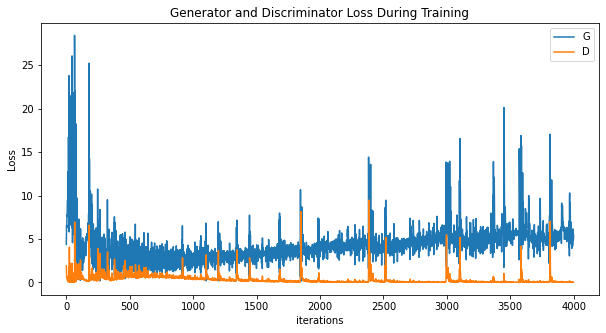

In [ ]:
#Below is a plot of D & G’s losses versus training iterations.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## GAN Image Progress

In [1]:
# uncomment to show the progress as an animation loop

# #%%capture
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

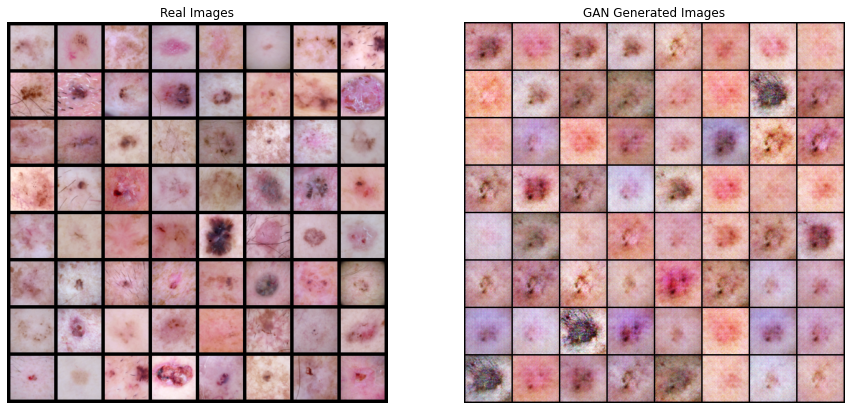

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("GAN Generated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Save Images

In [ ]:
def imgcrop(path, xPieces, yPieces):
    os.chdir(path)

    input = glob.glob("*.jpg")

    for x in range(len(input)):
      filename, file_extension = os.path.splitext(input[x])
      im = Image.open(path+input[0])
      imgwidth, imgheight = im.size
      height = imgheight // yPieces
      width = imgwidth // xPieces
      for i in range(0, yPieces):
          for j in range(0, xPieces):
              box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
              a = im.crop(box)
              try:
                a.save("/content/drive/MyDrive/skin_lesion/DCGAN/bcc/saved_images/cropped/" + filename + "-" + str(i) + "-" + str(j) + file_extension)
              except:
                  pass

    print("Final Images saved.")



def save_images(image_sample_size):
  temp_img = []
  img_list_temp = []
  for i in range(image_sample_size):
    generated_image = model(torch.randn(64, nz, 1, 1, device=device)).detach().cpu()
    temp_img.append(vutils.make_grid(generated_image, padding=0, normalize=True))
    img_list_temp.append(temp_img[-1].numpy())
    img_list_temp[-1] = img_list_temp[-1].transpose(1,2,0)
    plt.imsave('/content/drive/MyDrive/skin_lesion/DCGAN/bcc/saved_images/output/fake_{%d}.jpg' % (i) , img_list_temp[-1])
  print('Images Saved.')



In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/skin_lesion/DCGAN/vasc/saved_models/model_1450.pt')
model = Generator(nn.Module)
model.load_state_dict(checkpoint['modelG_state_dict'])
model.to('cuda')


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
save_images(image_sample_size)

Images Saved.


In [ ]:
imgcrop(OUT_DIR, 8, 8)

Final Images saved.


# **FID**

In [ ]:
pip install pytorch-fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.0-cp37-none-any.whl size=10547 sha256=08cf7984354603a24fa30219e4e55dea0e338faaed2900478bf1cccdcbfd926e
  Stored in directory: /root/.cache/pip/wheels/72/36/3c/4f3fb256f62d24bef52636f66f21667bc21caa637ce92f0e53
Successfully built pytorch-fid



### Class : akiec


Real - Real

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/fid/akiec/part_1/'   '/content/drive/MyDrive/skin_lesion/DCGAN/fid/akiec/part_2/'

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 110MB/s] 
  0% 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 4/4 [00:01<00:00,  3.98it/s]
100% 4/4 [00:00<00:00,  4.97it/s]
FID:  61.88992396098578


Real - Generated

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/akiec/gan_input/akiec'   '/content/drive/MyDrive/skin_lesion/DCGAN/akiec/saved_images/cropped'

  0% 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 7/7 [00:01<00:00,  4.75it/s]
100% 7/7 [00:24<00:00,  3.52s/it]
FID:  104.10763119775874


### Class : bcc

Real - Real

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/fid/bcc/part_1/'   '/content/drive/MyDrive/skin_lesion/DCGAN/fid/bcc/part_2/'

  0% 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 6/6 [00:01<00:00,  4.91it/s]
100% 6/6 [00:01<00:00,  5.20it/s]
FID:  57.20805562527096


Real - Generated

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/bcc/gan_input/bcc'  '/content/drive/MyDrive/skin_lesion/DCGAN/bcc/saved_images/cropped'

  0% 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 11/11 [00:02<00:00,  5.24it/s]
100% 11/11 [00:40<00:00,  3.72s/it]
FID:  118.32829618345053


### Class : bkl

Real - Real

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/fid/bkl/part_1/'   '/content/drive/MyDrive/skin_lesion/DCGAN/fid/bkl/part_2/'

  0% 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 11/11 [00:02<00:00,  4.89it/s]
100% 11/11 [00:02<00:00,  5.06it/s]
FID:  42.68884506661868


Real - Generated

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/bkl/gan_input/bkl'  '/content/drive/MyDrive/skin_lesion/DCGAN/bkl/saved_images/cropped'

  0% 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 22/22 [00:04<00:00,  5.23it/s]
100% 20/20 [00:03<00:00,  5.47it/s]
FID:  154.10941483290375


### Class : df

Real - Real

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/fid/df/part_1/'   '/content/drive/MyDrive/skin_lesion/DCGAN/fid/df/part_2/'

  0% 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 2/2 [00:00<00:00,  3.99it/s]
100% 2/2 [00:00<00:00,  4.79it/s]
FID:  121.43747388979278


Real - Generated

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/df/gan_input/df'  '/content/drive/MyDrive/skin_lesion/DCGAN/df/saved_images/cropped'

  0% 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3/3 [00:00<00:00,  4.21it/s]
100% 3/3 [00:12<00:00,  4.02s/it]
FID:  134.7975464640158


### Class : vasc

Real - Real

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/fid/vasc/part_1/'   '/content/drive/MyDrive/skin_lesion/DCGAN/fid/vasc/part_2/'

  0% 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 2/2 [00:00<00:00,  3.45it/s]
100% 2/2 [00:00<00:00,  4.16it/s]
FID:  146.82904802857968


Real - Generated

In [ ]:
!python -m pytorch_fid  '/content/drive/MyDrive/skin_lesion/DCGAN/vasc/gan_input/vasc'  '/content/drive/MyDrive/skin_lesion/DCGAN/vasc/saved_images/cropped'

  0% 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3/3 [00:00<00:00,  3.63it/s]
100% 3/3 [00:14<00:00,  4.99s/it]
FID:  155.33871988888473
